In [1]:
from random import choice, sample
from copy import deepcopy
from scipy.stats import bernoulli
from collections import Counter, defaultdict
from source.host import Host
from source.virus import Virus

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')
np.random.seed(45) # for reproducibility

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Agent-Based Model to Dissect Contribution of Host Immunity and Contact Structure to Influenza Reassortment

- Eric J. Ma
- Runstadler Lab Meeting
- If you want to follow along: https://github.com/ericmjl/reassortment-simulator

# Reassortment

- The reticulate evolutionary mechanism for the influenza virus.
- Implicated in all past human pandemics.
- Quantitatively important for host switches. (we're really excited about this finding!)

# Scientific Questions

- How does host contact structure affect the ability of a virus to shuffle its genome?
- How does host immunity affect the necessity of a virus to shuffle its genome?
- How does fitness of the virus within a host affect the ability of the virus to reassort? @Wendy
- How does waning immunity affect the necessity of the virus to reassort? @Jon

# Agent-Based Simulation Setup

- Two types of agents: `Host` and `Virus`.
- Interaction between hosts:
    - **Homophily**: degree of preference for interaction with the same color.
    - **Transmission**: passing on of virus.
- Interaction between viruses:
    - **Reassortment**: exchange of genes between viruses.
- Interaction between host and virus:
    - Host can gain **immunity** to viruses over time.
    - Virus has **host preference** of same color on one segment.

- `Host`:
    - `colour`
    - `immunity`
    - `viruses`
    - `expiry_time`
    - `alive_time`

- `Virus`:
    - `seg1color`
    - `seg2color`
    - `infection_time`
    - `expiry_time`

# Simulation Setup

In the following blocks of code, we will look at how the simulation will run.

# Initialization

1000 hosts: 500 red, 500 blue.

In [2]:
hosts = []
n_hosts = 1000
for i in range(n_hosts):
    if i < n_hosts / 2:
        hosts.append(Host(color='blue'))
    else:
        hosts.append(Host(color='red'))

# Initialization

Pick 5 red hosts, infect with one red virus each.

Pick 5 blue hosts, infect iwth one blue virus each.

In [3]:
# Pick 5 red hosts and 5 blue hosts at random, and infect it with a virus of the same color.
blue_hosts = [h for h in hosts if h.color == 'blue']
blue_hosts = sample(blue_hosts, 10)
blue_virus = Virus(seg1color='blue', seg2color='blue')
for h in blue_hosts:
    h.viruses.append(blue_virus)

red_hosts = [h for h in hosts if h.color == 'red']
red_hosts = sample(red_hosts, 10)
red_virus = Virus(seg1color='red', seg2color='red')
for h in red_hosts:
    h.viruses.append(red_virus)

# Parameters

In [4]:
p_immune = 1E-3   # 1 = always successful even under immune pressure
                  # 0 = always unsuccessful under immune pressure.
p_replicate = 0.95   # probability of replication given that a host is infected.
p_contact   = 1 - 1E-1/n_hosts  # probability of contacting a host of the same color.
p_same_color = 0.99   # probability of successful infection given segment of same color.
p_diff_color = 0.9    # probability of successful infection given segment of different color.
 
# Set up number of timesteps to run simulation
n_timesteps = 100

# Set up a defaultdict for storing data
data = defaultdict(list)

# Run Simulation!

In [5]:
# Run simulation
for t in range(n_timesteps):  
    # First part, clear up old infections.
    for h in hosts:
        h.increment_time()
        h.remove_old_viruses()
        h.remove_immune_viruses()
        
    # Step to replicate viruses present in hosts.
    infected_hosts = [h for h in hosts if h.is_infected()]
    for h in infected_hosts:
        if bernoulli.rvs(p_replicate): # we probabilistically allow replication to occur
            h.replicate_virus()
    
    # Step to transmit the viruses present in hosts.
    infected_hosts = [h for h in hosts if h.is_infected()]
    num_contacts = 0
    for h in infected_hosts:
        same_color = bernoulli.rvs(p_contact)
        if same_color:
            new_host = choice([h2 for h2 in hosts if h2.color == h.color])
            num_contacts += 0
        else:
            new_host = choice([h2 for h2 in hosts if h2.color != h.color])
            num_contacts += 1
        virus = h.viruses[-1] # choose the newly replicated virus every time.
        
        # Determine whether to transmit or not.
        p_transmit = 1
        ### First, check immunity ###
        if virus.seg1color in new_host.immunity:
            p_transmit = p_transmit * p_immune
        elif virus.seg1color not in new_host.immunity:
            pass
        
        ### Next, check seg1.
        if virus.seg1color == new_host.color:
            p_transmit = p_transmit * p_same_color
        else:
            p_transmit = p_transmit * p_diff_color
        
        ### Finally, check seg2.
        if virus.seg2color == new_host.color:
            p_transmit = p_transmit * p_same_color
        else:
            p_transmit = p_transmit * p_diff_color

        # Determine whether to transmit or not, by using a Bernoulli trial.
        transmit = bernoulli.rvs(p_transmit)
        
        # Perform transmission step
        if transmit:
            new_host.viruses.append(virus)
#             # Capture data in the summary graph.
#             if virus.is_mixed():
#                 G.edge[h.color][new_host.color]['mixed'] += 1
#             else:
#                 G.edge[h.color][new_host.color]['clonal'] += 1
        else:
            pass
        
        
    ### INSPECT THE SYSTEM AND RECORD DATA###
    
    num_immunes = 0  # num immune hosts
    num_infected = 0  # num infected hosts
    num_blue_immune = 0  # num blue immune hosts
    num_red_immune = 0  # num red immune hosts
    num_uninfected = 0  # num uninfected hosts
    num_mixed = 0  # num mixed viruses
    num_original = 0  # num original colour viruses
    num_red_virus = 0  # num red viruses
    num_blue_virus = 0  # num blue viruses
    
    for h in hosts:
        if len(h.immunity) > 0:
            num_immunes += 1
        if h.is_infected() > 0:
            num_infected += 1
        if 'blue' in h.immunity:
            num_blue_immune += 1
        if 'red' in h.immunity:
            num_red_immune += 1
        if not h.is_infected():
            num_uninfected += 1
            
        for v in h.viruses:
            if v.is_mixed():
                num_mixed += 1
            else:
                if v.seg1color == 'blue' and v.seg2color == 'blue':
                    num_blue_virus += 1
                elif v.seg1color == 'red' and v.seg2color == 'red':
                    num_red_virus += 1
                num_original += 1
    
    # Record data that was captured
    data['n_immune'].append(num_immunes)
    data['n_infected'].append(num_infected)
    data['n_blue_immune'].append(num_blue_immune)
    data['n_red_immune'].append(num_red_immune)
    data['n_uninfected'].append(num_uninfected)
    data['n_mixed'].append(num_mixed)
    data['n_original'].append(num_original)
    data['n_red_virus'].append(num_red_virus)
    data['n_blue_virus'].append(num_blue_virus)
    data['n_contacts'].append(num_contacts)
    ### INSPECT THE SYSTEM ###
    

# Result: Viral Dynamics

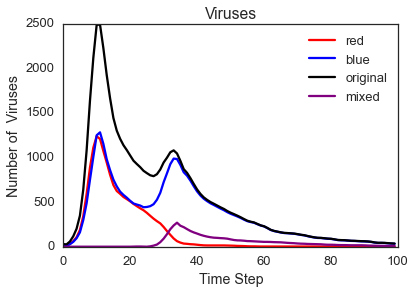

In [6]:
# Reassortment successful in establishing infection or not?
plt.plot(data['n_red_virus'], color='red', label='red')
plt.plot(data['n_blue_virus'], color='blue', label='blue')
plt.plot(data['n_original'], color='black', label='original')
plt.plot(data['n_mixed'], color='purple', label='mixed')
plt.ylabel('Number of  Viruses')
plt.xlabel('Time Step')
plt.title('Viruses')
plt.legend()

In [43]:
np.array_equal(np.array(data['n_mixed']), np.zeros(100))

False

In [44]:
np.where(np.array(data['n_mixed']) == np.max(data['n_mixed']))[0] - np.where(np.array(data['n_original']) == np.max(data['n_original']))[0]

array([14])

# Result: Host Immunity

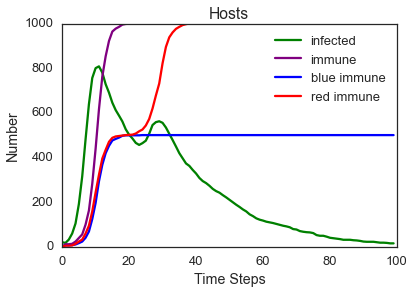

In [61]:
plt.plot(data['n_infected'], color='green', label='infected')
plt.plot(data['n_immune'], color='purple', label='immune')
plt.plot(data['n_blue_immune'], color='blue', label='blue immune')
plt.plot(data['n_red_immune'], color='red', label='red immune')
plt.ylabel('Number')
plt.xlabel('Time Steps')
plt.title('Hosts')
plt.legend()

# Result: Contact Frequency

array([14, 34, 35, 42])

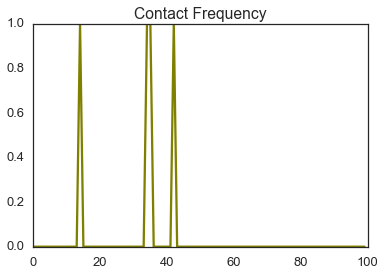

In [62]:
plt.plot(data['n_contacts'], color='olive', label='contacts')
plt.title('Contact Frequency')
np.where(np.array(data['n_contacts']) >= 1)[0]

In [47]:
import pandas as pd
pd.DataFrame(data)

,n_blue_immune,n_blue_virus,n_contacts,n_immune,n_infected,n_mixed,n_original,n_red_immune,n_red_virus,n_uninfected
0,0,14,0,0,20,0,29,0,15,980
1,6,12,0,11,17,0,26,5,14,983
2,6,28,0,11,32,0,58,5,30,968
3,6,56,0,11,60,0,118,5,62,940
4,10,100,0,22,109,0,202,12,102,891
5,18,180,0,39,193,0,349,21,169,807
6,26,328,0,53,320,0,633,27,305,680
7,47,569,0,93,490,0,1086,46,517,510
8,80,880,0,162,644,0,1664,82,784,356
9,139,1180,1,276,760,0,2235,137,1055,240


# Future Work

1. Code optimizations for 10-100X speedups in running simulations.
    1. Parallelization
    1. `Cython` or `numba`
1. Other metrics to measure beyond population immunity:
    1. Total duration of mixed virus emergence.
1. What's the parameter space where *unusual* things happen?